<font size = 6>EM Applications and its Extension - HMM</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> Nov 9, 2022</div></font>

In [1]:
import os
os.add_dll_directory("C:\Program Files\PSG\lib")

from hmmlearn.hmm import GaussianHMM as HMM
from sklearn.mixture import GaussianMixture as GMM
from scipy import integrate
from scipy.stats import norm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import math
import numpy as np
import pandas as pd
import psgpython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns

data_path = "D:\\Data\\"

In [2]:
def gen_norm_pdf(hmm_model, range_std = 3):
    mean_vec = hmm_model_y.means_.flatten()
    sigma_vec = np.sqrt(hmm_model_y.covars_.flatten())
    lo_vec = mean_vec - range_std * sigma_vec
    up_vec = mean_vec + range_std * sigma_vec
    x_vec = np.linspace(lo_vec.min(), up_vec.max(), int(1e5))
    y_vecs = []
    for i in range(mean_vec.shape[0]):
        curr_dist = norm(mean_vec[i], sigma_vec[i])
        y_vecs.append(curr_dist.pdf(x_vec))
    return np.array(x_vec), np.array(y_vecs), mean_vec, sigma_vec

In [3]:
def discrete_cvar(loss_vec, alpha, dist = "Uniform"):
    if dist != "Uniform":
        raise Exception("Only Accept Uniform Distribution!")

    data = np.sort(loss_vec)[::-1]
    alpha = 1 - alpha
    num = data.shape[0] - 1
    
    if int(num * alpha) == 0:
        raise Exception("Confidnece Level Alpha is not reasonable and is too large!")
    
    # Calculate VaR
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        var_num = int(num * alpha)
        var = data[var_num]    
    else:
        var_num = int(num * alpha)
        right = num * alpha - int(num * alpha)
        left = 1 - right
        var = left * data[var_num + 1] + right * data[var_num]
    # Calculate CVaR+ and CVaR-
    if math.isclose(int(num * alpha), num * alpha, rel_tol=1e-8):
        cvar_plus_num = int(num * alpha) - 1
        cvar_minus_num = int(num * alpha)
    else:
        cvar_plus_num = int(num * alpha)
        cvar_minus_num = int(num * alpha)
    cvar_plus = np.mean(data[:cvar_plus_num + 1])
    cvar_minus = np.mean(data[:cvar_minus_num + 1])
    # Calculate lambda
    phi = 1 - int(num * alpha) / num
    lambda_ = (phi - (1 - alpha)) / alpha
    cvar = var * lambda_ + cvar_plus * (1 - lambda_)
    return cvar, var, cvar_plus, cvar_minus, lambda_

In [4]:
def cvar_single_norm(mean, sigma, alpha):
    norm_dist = norm(mean, sigma)
    return (1 / (1 - alpha)) * integrate.quad(lambda x: x * norm_dist.pdf(x), norm_dist.ppf(alpha), np.inf)[0]

In [5]:
def GMM_Model(weight, mean, sigma):
    GMM_model = pd.DataFrame({"mean": mean, "sigma": sigma, "weight": weight}).sort_values(by = "weight", ascending = False)
    GMM_model.reset_index(drop = True, inplace = True)
    return GMM_model

In [6]:
def GMM_pdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.pdf(x_vec)
    
    return y_vec

In [7]:
def GMM_cdf(weight, mean, sigma, x_vec):
    GMM_model = GMM_Model(weight, mean, sigma)
    
    y_vec = np.array([0.] * x_vec.shape[0])
    for i in range(GMM_model.shape[0]):
        norm_dist = norm(GMM_model["mean"][i], GMM_model["sigma"][i])
        y_vec += GMM_model["weight"][i] * norm_dist.cdf(x_vec)
    
    return y_vec

In [8]:
def GMM_range(weight, mean, sigma, range_std = 4, prec = 1e-5):
    # If it is used to calculate CVaR, range_std must be 4!!
    GMM_model = GMM_Model(weight, mean, sigma)
    
    GMM_model_temp = GMM_model.copy()
    GMM_model_temp["upper_bound"] = GMM_model_temp["mean"] + range_std * GMM_model_temp["sigma"]
    GMM_model_temp["lower_bound"] = GMM_model_temp["mean"] - range_std * GMM_model_temp["sigma"] 
    up = GMM_model_temp["upper_bound"].max()
    lo = GMM_model_temp["lower_bound"].min()

    x_vec = np.linspace(lo, up, int(np.ceil((up - lo) / prec)))
    return x_vec

In [9]:
def GMM_ppf(weight, mean, sigma, alpha, prec = 1e-5):
    # ppf can be also defined as VaR
    GMM_model = GMM_Model(weight, mean, sigma)
    
    x_vec = GMM_range(weight, mean, sigma, prec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    ppf = x_vec[-(cdf_vec > alpha).sum():][0]
    
    return ppf, prec

In [10]:
def GMM_cvar(weight, mean, sigma, alpha, ppf_prec = 1e-5):
    GMM_model = GMM_Model(weight, mean, sigma)

    x_vec = GMM_range(weight, mean, sigma, 4, ppf_prec)
    pdf_vec = GMM_pdf(weight, mean, sigma, x_vec)
    cdf_vec = GMM_cdf(weight, mean, sigma, x_vec)
    
    step = x_vec[1] - x_vec[0]
    coef = cdf_vec[-(cdf_vec > alpha).sum():][-1] - cdf_vec[-(cdf_vec > alpha).sum():][0]
    approx_up = (x_vec[-(cdf_vec > alpha).sum() + 1:] * pdf_vec[-(cdf_vec > alpha).sum() + 1:]).sum() * step / coef
    approx_lo = (x_vec[-(cdf_vec > alpha).sum() : -1] * pdf_vec[-(cdf_vec > alpha).sum() : -1]).sum() * step / coef
    error = approx_up - approx_lo

    return approx_up, error

# Hidden Markov Model (HMM) for Gaussian distributions

## Implementation using hmmlearn - whole year 1 min data

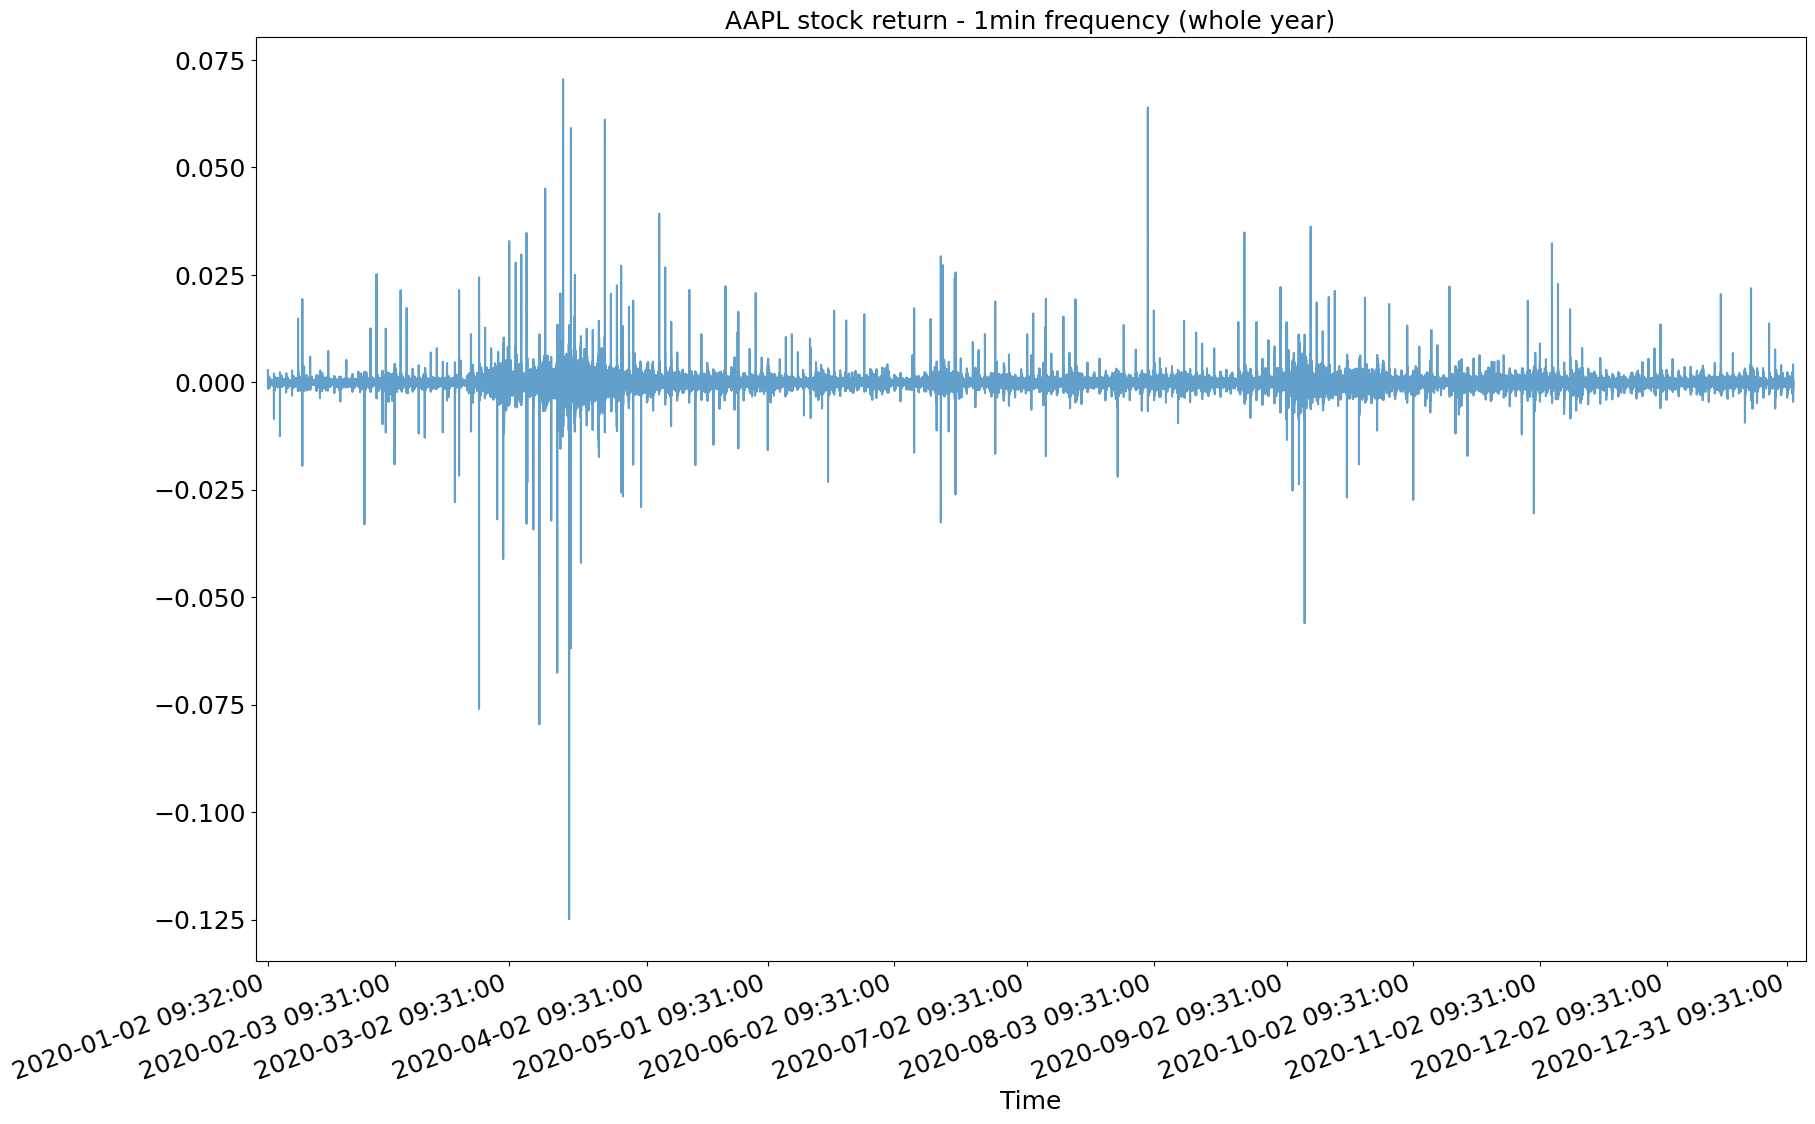

In [15]:
fig = plt.figure(figsize=(20, 12));
ax1 = fig.add_subplot(1, 1, 1);

ax1.plot(return_y.index, return_y.values, lw=1.5, alpha=0.7);

ax1.set_xlim(return_y.index[0], return_y.index[-1]);
ax1.set_xlim(ax1.get_xlim()[0] - 800, ax1.get_xlim()[1] + 800);

date_list = ['2020-01-02 09:32:00', '2020-02-03 09:31:00', '2020-03-02 09:31:00', '2020-04-02 09:31:00', '2020-05-01 09:31:00', 
             '2020-06-02 09:31:00', '2020-07-02 09:31:00', '2020-08-03 09:31:00', '2020-09-02 09:31:00', '2020-10-02 09:31:00', 
             '2020-11-02 09:31:00', '2020-12-02 09:31:00', '2020-12-31 09:31:00']
ax1.set_xticks(return_y.index[pd.Series(return_y.index).apply(lambda x: x in date_list).values]);
plt.xticks(fontsize=18, rotation=20, horizontalalignment="right");
plt.yticks(fontsize=18);
plt.xlabel("Time", fontsize=18);
plt.title("AAPL stock return - 1min frequency (whole year)", fontsize=18);

In [16]:
# hmm_models_y = []
# lnL_2, aic_2, bic_2 = [], [], []
# num_p = 41
#
# for num_state in range(2, num_p):
#     # try large "n_iter" and different "random state" will improve the accuracy of the algorithm a lot!    
#     model = HMM(n_components=num_state, random_state=343).fit(return_y.values.reshape(-1, 1))
#   
#     if not model.monitor_.converged:
#         raise Exception("Did not converge, please check!")
#   
#     hmm_models_y.append(model)
#     lnL_2.append(model.score(return_y.values.reshape(-1, 1)))
#     # initial node prob + emission matrix of Gaussian + transition matrix
#     k = num_state + 2 * num_state + num_state ** 2
#   
#     aic_2.append(- 2 * lnL_2[-1] + 2 * k)
#     bic_2.append(- 2 * lnL_2[-1] + np.log(n) * k)
#
# hmm_result_y = pd.DataFrame({"LL": lnL_2, "AIC": aic_2, "BIC": bic_2}, index = list([i for i in range(2, num_p)]))
# np.save(".\year_npy\\hmm_result_y.npy", hmm_result_y)
# np.save(".\\year_npy\\hmm_models_y.npy", hmm_models_y)

hmm_models_y = np.load(".\\year_npy\\hmm_models_y.npy", allow_pickle = True)
hmm_result_y = np.load(".\\year_npy\\hmm_result_y.npy", allow_pickle = True)
hmm_result_y = pd.DataFrame(hmm_result_y, index = list([i for i in range(2, 41)]))
hmm_result_y.rename(columns = {0: 'LL', 1: 'AIC', 2:'BIC'}, inplace = True)

In [17]:
def plot_hmm_result(results, opt, title):
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(2, 1, 1)

    ax1.plot(results.index, results["LL"], lw=2.5, label="Log-Likelihood Function value", c="r")
    ylim = ax1.get_ylim()
    ax1.scatter(results.index[opt], results["LL"].iloc[opt], zorder=2, color="k", label="(Sub)Optimal states number")
    ax1.scatter(results.index[opt], ylim[0], zorder=2, color="k")
    ax1.plot([results.index[opt]] * 200, np.linspace(ylim[0], results["LL"].iloc[opt], 200), linestyle = "--", color = "k", zorder=2)
    ax1.text(results.index[opt]+0.2, results["LL"].iloc[opt], '%.1f'%(results["LL"].iloc[opt]), fontsize=16)
    ax1.text(results.index[opt]+0.2, ylim[0]+(ylim[1]-ylim[0])*0.005, results.index[opt], fontsize=16)
    ax1.set_ylim(ylim[0], ylim[1])
    
    ax1.set_title(title, fontsize=18)
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3E'))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(results.index, results["AIC"], lw=2.5, label="AIC")
    ax2.plot(results.index, results["BIC"], lw=2.5, label="BIC")
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3E'))
    # ax2.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    plt.xlabel("Number of states", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

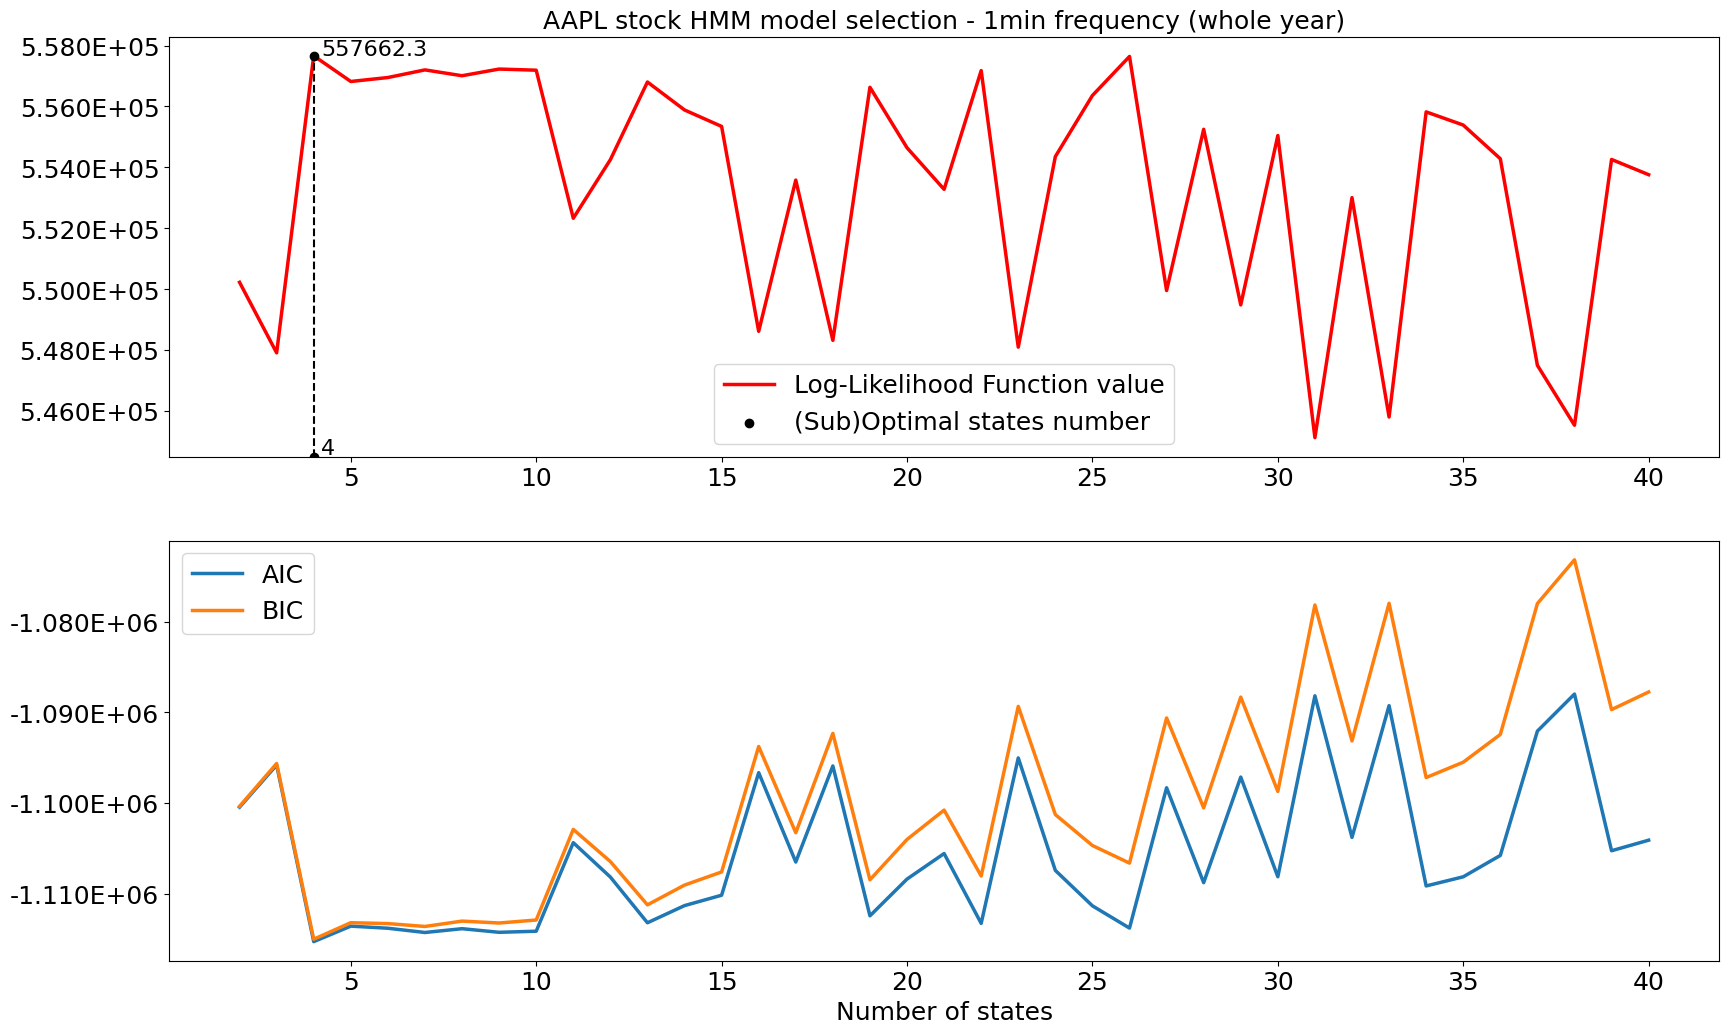

In [18]:
plot_hmm_result(hmm_result_y, 2, "AAPL stock HMM model selection - 1min frequency (whole year)")

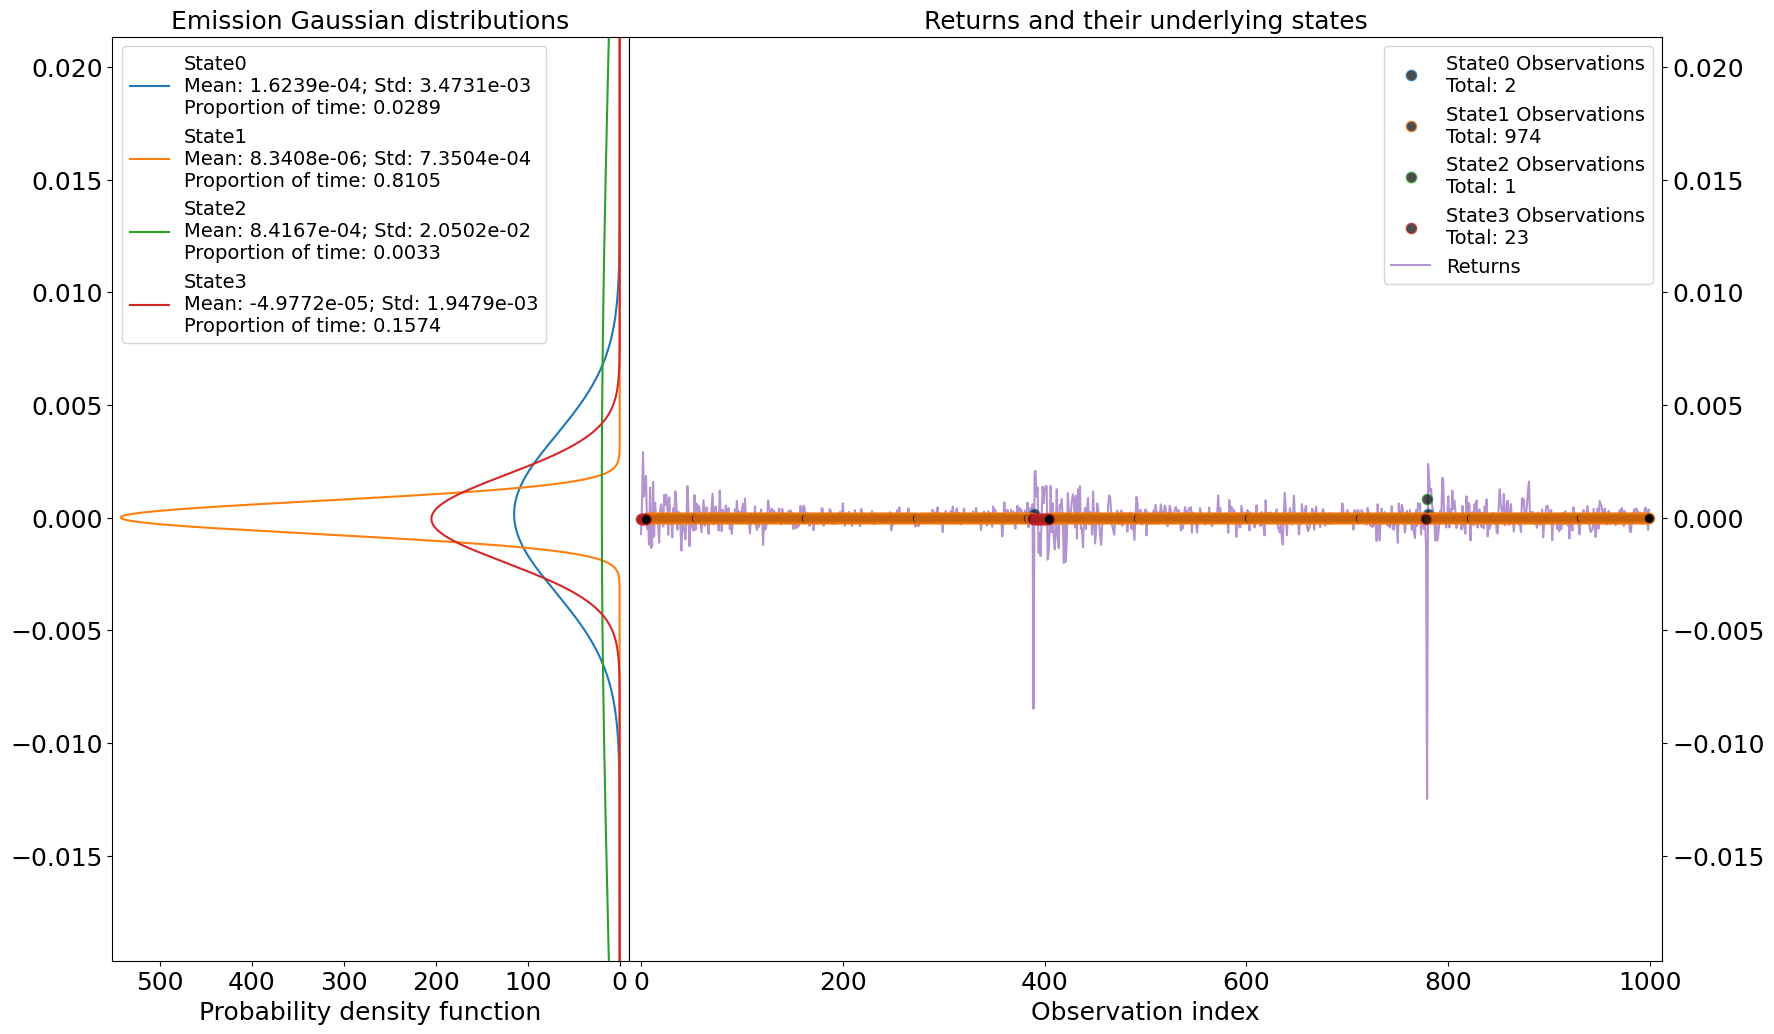

In [19]:
hmm_model_y = hmm_models_y[2]
# use the Viterbi algorithm to predict the most likely sequence of states given the model
states_y = hmm_model_y.predict(return_y.values.reshape(-1, 1))
prop_per_state = hmm_model_y.predict_proba(return_y.values.reshape(-1, 1)).mean(axis=0)
# plot model states over time
fig = plt.figure(figsize=(20, 12));
plt.subplots_adjust(wspace=0);

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan = 1);
x_vec, y_vecs, mean_vec, sigma_vec = gen_norm_pdf(hmm_model_y, range_std = 1)
for i in range(hmm_model_y.n_components):
    ax1.plot(y_vecs[i], x_vec, label = "State%d\nMean: %.4e; Std: %.4e\nProportion of time: %.4f" % (i, mean_vec[i], sigma_vec[i], prop_per_state[i]));
ax1.set_xlim(int(y_vecs.max() + 10), -10);
ax1.set_ylim(x_vec[0], x_vec[-1]);
ax1.set_title("Emission Gaussian distributions", fontsize=18);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.legend(fontsize=14);
plt.xlabel("Probability density function", fontsize=18);

plot_num = 1000
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2);
for i in range(hmm_model_y.n_components):
    index = np.where(states_y[:plot_num] == i)
    ax2.plot(index[0], hmm_model_y.means_[states_y[:plot_num]].flatten()[index[0]], 
             ".", ms=15, mfc="k", label = "State%d Observations\nTotal: %d" % (i, index[0].shape[0]), alpha=0.7, zorder=2);
ax2.plot(return_y.values[:plot_num], lw=1.5, alpha=0.7, zorder=1, label = "Returns");
    
ax2.set_xlim(-int(plot_num/80), plot_num + int(plot_num/80));
ax2.set_ylim(x_vec[0], x_vec[-1]);
ax2.set_xlabel("Observation index", fontsize=18);
ax2.set_title("Returns and their underlying states", fontsize=18);
ax2.tick_params(labelleft=False, left=False, labelright=True, right=True);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.legend(fontsize=14);

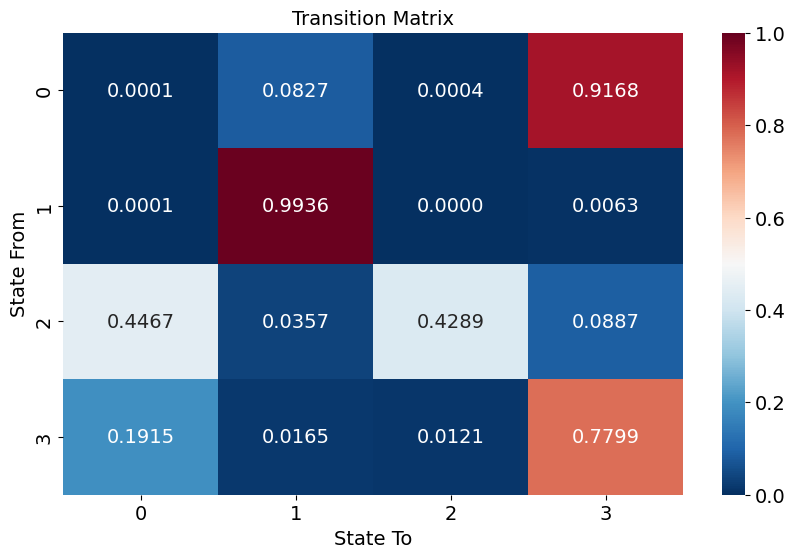

In [20]:
# Display transition matrix
fig = plt.figure(figsize=(10, 6));
ax1 = fig.add_subplot(1, 1, 1)
sns1 = sns.heatmap(data=hmm_model_y.transmat_, vmin=0, vmax=1, ax=ax1, cmap ="RdBu_r", annot=True, fmt=".4f", annot_kws={"fontsize":14})
cbar = sns1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
ax1.set_title('Transition Matrix', fontsize=14)
ax1.set_xlabel('State To', fontsize=14)
ax1.set_ylabel('State From', fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

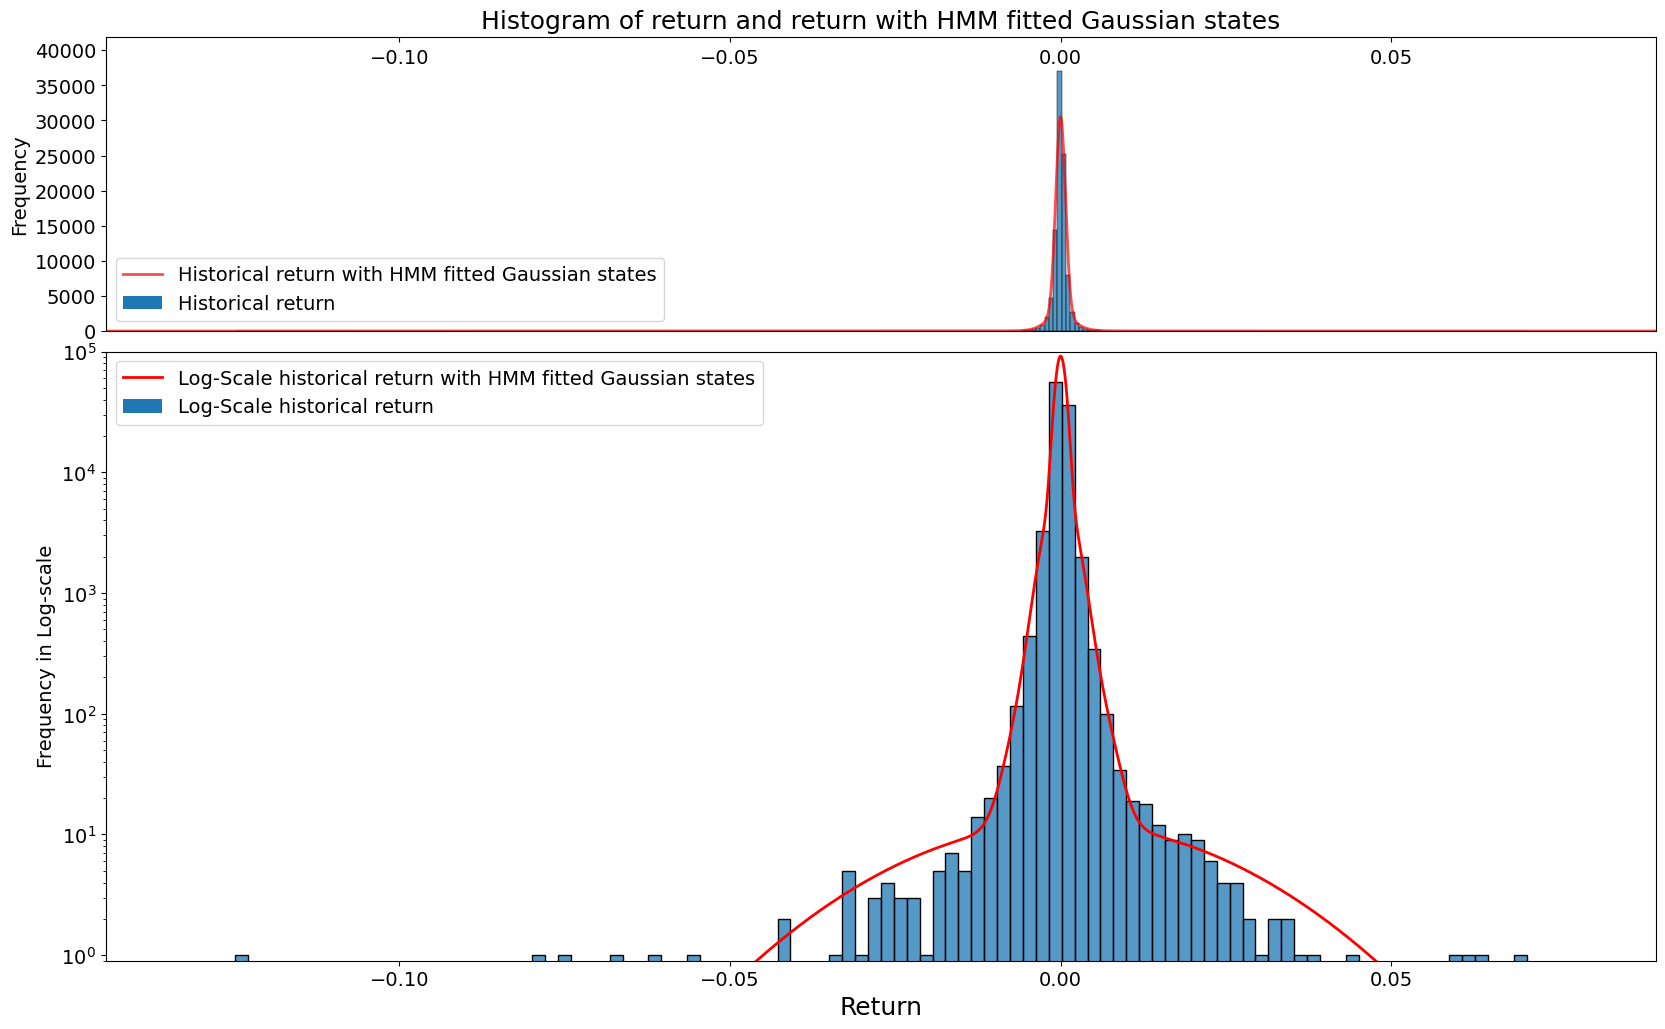

In [21]:
bin_num1, bin_num2 = 300, 100
x_range = return_y.max() - return_y.min()
xlim = [return_y.min() - 0.1 * x_range, return_y.max() + 0.1 * x_range]
x_vec = np.linspace(xlim[0], xlim[1], int(1e5))
y_vec = GMM_pdf(prop_per_state, mean_vec, sigma_vec, x_vec)
y_vec1 = y_vec * np.histogram(return_y, bins=bin_num1)[0].max() / np.histogram(return_y, bins=bin_num1, density=True)[0].max()
y_vec2 = y_vec * np.histogram(return_y, bins=bin_num2)[0].max() / np.histogram(return_y, bins=bin_num2, density=True)[0].max()

fig = plt.figure(figsize=(20, 12));
plt.subplots_adjust(hspace=0.07);

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1);
sns.histplot(data=return_y, bins=bin_num1, stat="count", ax=ax1, label="")
ax1.plot(x_vec, y_vec1, c="r", lw=2, alpha=0.7);
ax1.set_xlim(xlim)
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1]+3000)
ax1.set_title('Histogram of return and return with HMM fitted Gaussian states', fontsize=18)
ax1.set_xlabel('', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis="x", labeltop=True, top=True, labelbottom=False, bottom=False, direction="in", pad=-22);
ax1.legend(["Historical return with HMM fitted Gaussian states", "Historical return"], loc="lower left", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2);
sns2 = sns.histplot(data=return_y, bins=bin_num2, stat="count", ax=ax2, label="Return histogram - Log-scale");
ax2.plot(x_vec, y_vec2, c="r", lw=2);
sns2.axes.set_yscale('log')
ax2.set_ylim(0.9,100000);
ax2.set_xlim(xlim)
ax2.set_title('', fontsize=14)
ax2.set_xlabel('Return', fontsize=18)
ax2.set_ylabel('Frequency in Log-scale', fontsize=14)
ax2.legend(["Log-Scale historical return with HMM fitted Gaussian states", "Log-Scale historical return"], loc="upper left", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);